In [1]:
import torch
from kan import *
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
torch.set_default_dtype(torch.float64)

In [2]:
df=pd.read_csv('data/processed_country_data.csv')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
df.isnull().sum().sum()

0

In [5]:
df = pd.DataFrame(df)

In [6]:
df.head()

,iso_code,continent,location,date,new_cases,new_deaths,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,new_deaths_smoothed_lag_1,new_deaths_smoothed_lag_2,new_deaths_smoothed_lag_3,new_deaths_smoothed_lag_4,new_deaths_smoothed_lag_5,total_cases_lag_1,total_cases_lag_2,total_cases_lag_3,total_cases_lag_4,total_cases_lag_5
0,AFG,Asia,Afghanistan,2020-01-10,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AFG,Asia,Afghanistan,2020-01-11,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AFG,Asia,Afghanistan,2020-01-12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AFG,Asia,Afghanistan,2020-01-13,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AFG,Asia,Afghanistan,2020-01-14,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
countries_near_vietnam = [
    'Vietnam',
    'Thailand',
    'Laos',
    'Cambodia',
    'China',
    'Malaysia',
    'Singapore',
    'Indonesia',
    'Philippines',
    'Brunei',
    'South Korea',
    'Japan'
]

In [8]:
df = df[df['continent'] == 'Asia']
df = df[df['location'].isin(countries_near_vietnam)]
df.shape

(20027, 43)

In [9]:
selected_features = [
    'new_cases_smoothed_lag_5',
    'new_cases_smoothed_lag_3',
    'new_cases_smoothed_lag_1',
    'new_cases_smoothed_lag_4',
    'new_cases_smoothed_lag_2',
    'new_deaths_smoothed_lag_5',
    'new_deaths_smoothed_lag_3',
    'new_deaths_smoothed_lag_1',
    'total_deaths_lag_5',
    'total_deaths_lag_3',
    'total_deaths_lag_1',
    'population',
    'new_deaths_smoothed_lag_4',
    'new_deaths_smoothed_lag_2'
]

In [10]:
X = df[selected_features]
y = df[['new_cases_next_day']]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Size of X_train: {X_train.shape}")
print(f"Size of X_test: {X_test.shape}")
print(f"Size of y_train: {y_train.shape}")
print(f"Size of y_test: {y_test.shape}")

Size of X_train: (16021, 14)
Size of X_test: (4006, 14)
Size of y_train: (16021, 1)
Size of y_test: (4006, 1)


In [12]:
print("--- Dữ liệu gốc (trước chuẩn hóa) ---")
print("X_train shape:", X_train.shape, " | y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape, " | y_test shape:", y_test.shape)
print("X_train (min/max):", X_train.min().min(), "/", X_train.max().max()) # Dùng min().min() cho DataFrame
print("y_train (min/max):", y_train.min().min(), "/", y_train.max().max())

--- Dữ liệu gốc (trước chuẩn hóa) ---
X_train shape: (16021, 14)  | y_train shape: (16021, 1)
X_test shape: (4006, 14)  | y_test shape: (4006, 1)
X_train (min/max): 0.0 / 1425887360.0
y_train (min/max): 0.0 / 40475477.0


In [13]:
# --- 1. Chuẩn hóa Input (X_train, X_test) ---

# Khởi tạo StandardScaler cho input
scaler_X = StandardScaler()

# CHỈ fit scaler trên X_train để học các tham số chuẩn hóa (mean, std) từ tập huấn luyện
X_train_scaled = scaler_X.fit_transform(X_train)

# Transform X_test sử dụng scaler đã fit từ X_train
X_test_scaled = scaler_X.transform(X_test)

In [14]:
# --- 2. Chuẩn hóa Label (y_train, y_test) ---

# Khởi tạo StandardScaler cho label
scaler_y = StandardScaler()

# CHỈ fit scaler trên y_train
# y_train cần được reshape nếu nó là Series (dạng (N,)) để trở thành 2D (dạng (N, 1))
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

# Transform y_test sử dụng scaler đã fit từ y_train
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [15]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float64).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float64).to(device)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float64).to(device)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float64).to(device) 

In [16]:
dataset={}
dataset['train_input'] = X_train_tensor
dataset['test_input'] = X_test_tensor
dataset['train_label'] = y_train_tensor
dataset['test_label'] = y_test_tensor

In [17]:
steps = 50
grid=3

checkpoint directory created: ./model
saving model version 0.0


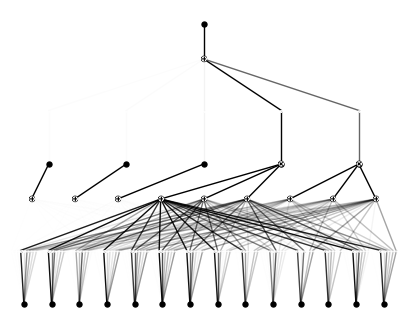

In [18]:
model = KAN(width=[dataset['train_input'].shape[1],[3,2],1], mult_arity=3,base_fun='identity',grid=grid,device=device)
model.get_act(dataset)
model.plot() 

In [19]:
model.fit(dataset, steps=steps, opt='LBFGS', lamb=0.01, lamb_coef=1.0);

| train_loss: 8.42e-01 | test_loss: 2.76e+00 | reg: 6.61e+02 | : 100%|█| 100/100 [01:34<00:00,  1.06

saving model version 0.1


saving model version 0.2


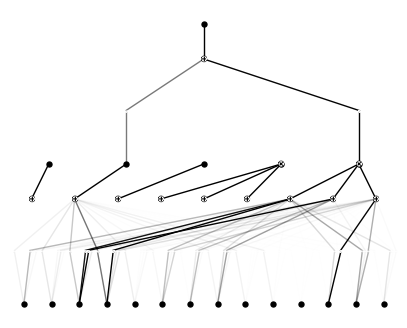

In [20]:
model.prune()
model.plot()

In [21]:
train_losses = []
test_losses = []

results = model.fit(dataset, opt='LBFGS', steps=50)
train_losses += results['train_loss']
test_losses += results['test_loss']

| train_loss: nan | test_loss: nan | reg: 0.00e+00 | :  44%|███▌    | 22/50 [00:16<00:21,  1.30it/s]


KeyboardInterrupt: 

In [ ]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

In [ ]:
model.plot(metric='forward_n')

In [ ]:
model.feature_score